# Exam project of group 26
### Group members:
- Baltazar Dydensborg
- Johan Kielgast Ladelund
- Laura Weile
- Simon Juul Hansen

### Research Question:
Vi skal have fundet på noget.

SI SI SI SI SI SI SI SI SI SI SI SI SI SI SI SI
si

### All of the dependency imports

In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import datetime
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

import time
#from selenium import webdriver
from seleniumwire import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver import ActionChains
from collections import defaultdict
import scraping_class

s = requests.Session()
# update headers to the requests
s.headers.update({'contact_details': 'qxd466@alumni.ku.dk', 'purpose': "Dear recipient, we've scraped your data with the purpose of creating an academic report on electricity prices and if it's possible to predict these. Please contact us at via the contact details, if there's any issue with this. Best regards."})
conn = scraping_class.Connector(logfile="log.csv", overwrite_log=False, session = s)

# Elpriser fra Nordpool

In [46]:
def getElspotPrices():
    # Get the json data from Nordpool
    url = 'https://www.nordpoolgroup.com/api/downloads/4675'
    el_res, _ = conn.get(url, "Nordpool Data")
    el_json = el_res.json()

    # Selects the urls for the hourly elspot prices in DKK
    hourly = [i for i in el_json['Files'] if i['Resolution'] == 'Hourly']
    elspot = [i for i in hourly if i['Categories'] == ['Elspot Prices']]
    elspot = [i for i in elspot if i['Name'].endswith('DKK')]
    elspot_url = ['https://www.nordpoolgroup.com'+i['Url'] for i in elspot]

    # Create a dictonary with all of the data for each year and put it into a DataFrame
    d = {}
    for i in range(len(elspot_url)):
        d[f'DF_{2013+i}'] = pd.read_html(elspot_url[i])[0].droplevel(level = 0, axis = 1).droplevel(level = 0, axis = 1)

    # Standardize the 2021 dataset
    #d['DF_2021'] = d['DF_2021'].droplevel(level = 0, axis = 1).rename(columns= {'Unnamed: 0_level_3': 'Unnamed: 0_level_2'})

    # Concat the DataFrames into one DF
    df_concat = pd.concat(d)

    # Structure the DataFrame
    df_new = df_concat[['Unnamed: 0_level_2', 'Hours', 'SYS','DK1','DK2']].droplevel(level = 0).reset_index(drop = True)
    df_new[df_new.columns[2:]] = df_new[df_new.columns[2:]]/100
    df_new = df_new.rename(columns = {'Unnamed: 0_level_2': 'date'})

    # Add datetime columns
    df_new['date'] = pd.to_datetime(df_new['date'], format = '%d-%m-%Y')
    df_new['hour'] = df_new['Hours'].str[5:]
    df_new.drop('Hours', axis = 1, inplace = True)
    df_new['hour'] = pd.to_datetime(df_new['hour'], format = '%H').dt.hour

    # Make the index into datetime
    df_new.index = pd.to_datetime(df_new['date'].apply(str)+' '+pd.to_datetime(df_new['hour'], format = '%H').dt.time.apply(str))

    return df_new

In [34]:
nordpool_df = getElspotPrices()

<AxesSubplot:>

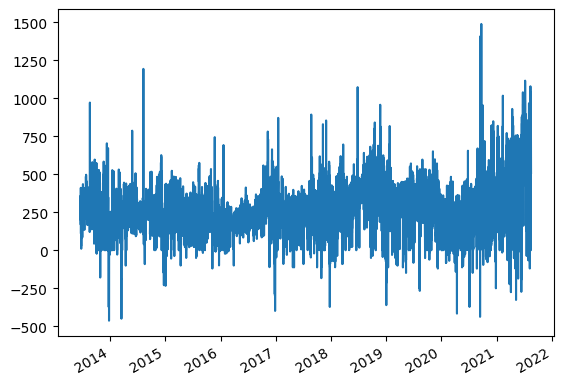

In [35]:
plt.style.use('default')
#nordpool_df[['SYS', 'DK1', 'DK2']][4000:4000+8760].plot(subplots=True, layout=(1,3), figsize = (20,5), sharey= True);
nordpool_df['DK1'][4000:].plot()

# Nordpool data


We import the required packages

In [19]:
import requests
from bs4 import BeautifulSoup
import re
import selenium
import time
import pandas as pd
import scraping_class

We identify the [webpage](https://www.nordpoolgroup.com/historical-market-data/) with the desired information stored as seperate htlm files.

However, we are not able to scrape Nordpool to obtain the individual links for the files as the webpage call an internal API. Luckily we are able to call the API and obtain the JSON. 

## Consumption Prognosis


In [45]:
def ConsumptionPrognosis():
    # Get the json from the internal API on Nordpool.com
    url = "https://www.nordpoolgroup.com/api/downloads/4675"
    res, _ = conn.get(url, "Nordpool Data")
    page = res.json()

    # Get the URLs for the html files containing the hourly consumption prognosis' and transform them into a list
    # of dataframes 
    hourly = [i for i in page["Files"] if i["Resolution"] == "Hourly"]
    Categories = [i for i in hourly if i["Categories"] == ["Consumption prognosis"]]
    DKK = [i for i in Categories if "DK" in i["Name"]]
    URLS_CP = ["https://www.nordpoolgroup.com"+i["Url"] for i in DKK]
    df_con_prog = [pd.read_html(i)[0].droplevel(level = 0, axis = 1).droplevel(level = 0, axis = 1) for i in URLS_CP]

    # Concatenate the dataframes, rename, and format time stamp
    df_CP = pd.concat(df_con_prog)
    cols = ["Unnamed: 0_level_2", "Hours", "DK1", "DK2"]
    df_CP = df_CP[cols].rename(columns = {"Unnamed: 0_level_2": "date", "DK1": "DK1_CP", "DK2": "DK2_CP"})
    df_CP["date"] = pd.to_datetime(df_CP["date"], format = "%d-%m-%Y")
    df_CP["hour"] = df_CP["Hours"].str[5:]
    df_CP.drop('Hours', axis = 1, inplace = True)
    df_CP["hour"] = pd.to_datetime(df_CP["hour"], format = '%H').dt.hour

    # Set index equal to time stamp 
    df_CP.index = pd.to_datetime(df_CP["date"].apply(str)+' '+pd.to_datetime(df_CP["hour"], format = '%H').dt.time.apply(str))

    return df_CP

## Production Prognosis
We extract the production prognosis. The decimal pointer are correct for the consumption prognosis data sets.

In [44]:
def ProductionPrognosis(): 
    # Get the json from the internal API on Nordpool.com
    url = "https://www.nordpoolgroup.com/api/downloads/4675"
    res, _ = conn.get(url, "Nordpool Data")
    page = res.json()

    # Get the URLs for the html files containing the hourly consumption prognosis' and transform them into a list
    # of dataframes 
    hourly = [i for i in page["Files"] if i["Resolution"] == "Hourly"]
    Categories = [i for i in hourly if i["Categories"] == ["Production prognosis"]]
    URLS_PP = ["https://www.nordpoolgroup.com"+i["Url"] for i in Categories]
    df_pro_prog = [pd.read_html(i)[0].droplevel(level = 0, axis = 1).droplevel(level = 0, axis = 1) for i in URLS_PP]

    # Concatenate the dataframes, rename, and format time stamp
    df_PP = pd.concat(df_pro_prog)
    cols = ["Unnamed: 0_level_2", "Hours", "DK1", "DK2"]
    df_PP = df_PP[cols].rename(columns = {"Unnamed: 0_level_2": "date", "DK1": "DK1_PP", "DK2": "DK2_PP"})
    df_PP["date"] = pd.to_datetime(df_PP["date"], format = "%d-%m-%Y")
    df_PP["hour"] = df_PP["Hours"].str[5:]
    df_PP.drop('Hours', axis = 1, inplace = True)
    df_PP["hour"] = pd.to_datetime(df_PP["hour"], format = '%H').dt.hour


    # Set index equal to time stamp 
    df_PP.index = pd.to_datetime(df_PP["date"].apply(str)+' '+pd.to_datetime(df_PP["hour"], format = '%H').dt.time.apply(str))

    return df_PP

## Wind Power Prognosis
We extract the wind power prognosis. The decimal pointer are correct for the consumption prognosis data sets.

In [43]:
def WindPrognosis():
    # Get the json from the internal API on Nordpool.com
    url = "https://www.nordpoolgroup.com/api/downloads/4675"
    res, _ = conn.get(url, "Nordpool Data")
    page = res.json()

    # Get the URLs for the html files containing the hourly consumption prognosis' and transform them into a list
    # of dataframes 
    hourly = [i for i in page["Files"] if i["Resolution"] == "Hourly"]
    Categories = [i for i in hourly if i["Categories"] == ["Wind power prognosis"]]
    DKK = [i for i in Categories if "DK" in i["Name"]]
    URLS_WP = ["https://www.nordpoolgroup.com"+i["Url"] for i in DKK]
    df_wind_prog = [pd.read_html(i)[0].droplevel(level = 0, axis = 1).droplevel(level = 0, axis = 1) for i in URLS_WP]

    # Concatenate the dataframes, rename, and format time stamp
    df_WP = pd.concat(df_wind_prog)
    cols = ["Unnamed: 0_level_2", "Hours", "DK1", "DK2"]
    df_WP = df_WP[cols].rename(columns = {"Unnamed: 0_level_2": "date", "DK1": "DK1_WP", "DK2": "DK2_WP"})
    df_WP["date"] = pd.to_datetime(df_WP["date"], format = "%d-%m-%Y")
    df_WP["hour"] = df_WP["Hours"].str[5:]
    df_WP.drop('Hours', axis = 1, inplace = True)
    df_WP["hour"] = pd.to_datetime(df_WP["hour"], format = '%H').dt.hour


    # Set index equal to time stamp 
    df_WP.index = pd.to_datetime(df_WP["date"].apply(str)+' '+pd.to_datetime(df_WP["hour"], format = '%H').dt.time.apply(str))

    return df_WP

## Power Exchange 
We extract the power exchange. We change the value og observation to fix the misplaced decimal pointer when relevant. 

In [42]:
def ExchangeConnections():
    # Get the json from the internal API on Nordpool.com
    url = "https://www.nordpoolgroup.com/api/downloads/4675"
    res, _ = conn.get(url, "Nordpool Data")
    page = res.json()

    # Get the URLs for the html files containing the hourly consumption prognosis' and transform them into a list
    # of dataframes 
    hourly = [i for i in page["Files"] if i["Resolution"] == "Hourly"] 
    Categories = [i for i in hourly if i["Categories"] == ["Exchange connections"]]
    DKK = [i for i in Categories if "DK" in i["Name"]]
    URLS_Ex = ["https://www.nordpoolgroup.com"+i["Url"] for i in DKK]

    # We obain two datasets for 2015 and by inspecting the data sets we realize that the set called: 
    # 'https://www.nordpoolgroup.com/48e277/globalassets/marketdata-excel-files/exchange-dk-connections_2015_hourly2.xls',
    # is the data of intereset
    
    URLS_Ex.pop(2)
    df_Exchange = [pd.read_html(i)[0].droplevel(level = 0, axis = 1).droplevel(level = 0, axis = 1) for i in URLS_Ex]

    # Concatenate the dataframes, rename, fix misplaced decimal pointer, and format time stamp
    df_Ex = pd.concat(df_Exchange)
    df_Ex = df_Ex.rename(columns = {"Unnamed: 0_level_2": "date"})
    df_Ex["date"] = pd.to_datetime(df_Ex["date"], format = "%d-%m-%Y")

    df_Ex["hour"] = df_Ex["Hours"].str[5:]
    df_Ex.drop('Hours', axis = 1, inplace = True)
    df_Ex["hour"] = pd.to_datetime(df_Ex["hour"], format = '%H').dt.hour

    cols = ["DK - DE", "DK - NO", "DK - SE", "DK1 - SE3", "DK2 - SE4", "DK1 - DE", "DK2 - DE", "DK1 - DK2", "DK1 - NL"]
    df_Ex[cols] = df_Ex[cols]/100

    # Set index equal to time stamp 
    df_Ex.index = pd.to_datetime(df_Ex["date"].apply(str)+' '+pd.to_datetime(df_Ex["hour"], format = '%H').dt.time.apply(str))

    return df_Ex


## Merging data


In [116]:
# Creating function to merge dataframes from the Nordpool database
def mergeNordpool(list_of_dfs):
    df_Nordpool = list_of_dfs[0]
    for df in list_of_dfs[1:]:
        df_Nordpool = pd.merge(df_Nordpool, df, how = "outer", on = ["date", "hour"])
    df_Nordpool.reset_index(drop = True)
    return df_Nordpool

# Creating final dataframe 
df_Nordpool = mergeNordpool([getElspotPrices(), ConsumptionPrognosis(), ProductionPrognosis(), WindPrognosis(), ExchangeConnections()])

NameError: name 'getElspotPrices' is not defined

# Vejr data fra DMI API

In [48]:
# Constants

metObsAPIKey = 'c4503ba1-28d4-45c5-850a-974e98bbb3e0'
climateDataAPIKey = 'ac27b332-bde2-4138-a53e-f0ca82cf3667'
stationId = 6183

dmi_url= lambda API_KEY: f'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items?limit=300000&stationId=06184&parameterId=temp_dry&bbox=7,54,16,58&datetime=2015-01-01T00:00:00Z/2021-08-01T00:00:00Z&api-key={API_KEY}'
dmi_url_id= lambda API_KEY, id: f'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items?limit=300000&stationId=06184&parameterId={id}&bbox=7,54,16,58&datetime=2015-01-01T00:00:00Z/2021-08-01T00:00:00Z&api-key={API_KEY}'
dmi_url_allID= lambda API_KEY: f'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items?limit=300000&stationId=06184&bbox=7,54,16,58&datetime=2015-01-01T00:00:00Z/2021-08-01T00:00:00Z&api-key={API_KEY}'


In [49]:
def getMetObsData(stat, start_date, end_date, stationId = '06183', apiKey = metObsAPIKey):
    """
    Function that takes a parameter ID and searches for all observations from DMI
    for the given dates, where the date format is given as 'YYYY-MM-DD'
    """

    # Define constants to be used in the function
    url= lambda API_KEY, id, startDate, endDate, stationId: f'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items?limit=300000&stationId={stationId}&parameterId={id}&bbox=7,54,16,58&datetime={startDate}T00:00:00Z/{endDate}T00:00:00Z&api-key={API_KEY}'
    local_counter = 1
    ErrorCounter = 0
    stationCounter = 0

    while True:
        try:
            temp_url = url(apiKey, stat, start_date, end_date, stationId)
            ErrorCounter += 1

            res, _ = conn.get(temp_url, 'DMI Data')
            json_dmi = res.json()
            prop = [item['properties'] for item in json_dmi['features']]
            temp_df = pd.DataFrame(prop)
            
            temp_df['observed'].drop_duplicates(inplace = True)
            temp_df.index = pd.to_datetime(temp_df['observed'])
            temp_df = temp_df.tz_convert('CET')

            if temp_df.index[-1].date() != datetime.date.fromisoformat(start_date):
                            
                if local_counter == 1:
                    df_met_obs_func = temp_df.copy()
                    local_counter += 1
                elif local_counter > 1:
                    df_met_obs_func = pd.concat([df_met_obs_func,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in IF")

                end_date = temp_df.index[-1].date().strftime("%Y-%m-%d")
                continue
            else:
                if local_counter == 1:
                    df_met_obs_func = temp_df
                elif local_counter > 1:
                    df_met_obs_func = pd.concat([df_met_obs_func,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in ELSE")

                break
            


        except KeyError as e:

            try:
                df_met_obs_func
            except NameError:
                return temp_df
            else:
                return df_met_obs_func
        
    return df_met_obs_func

        
    

In [50]:
def metObsNaFiller(stat, start_date, end_date):
    stationList = ['06184', '06186', '06187', '06188']

    # Create the DF for the first and default station
    df = getMetObsData(stat, start_date, end_date)

    # Fill in the NAs with observations from all stations listed above
    for station in stationList:
        df = df.combine_first(getMetObsData(stat, start_date, end_date, stationId = station))

    return df

In [51]:
def getClimateData(stat, start_date, end_date, stationId = '06184',apiKey = climateDataAPIKey):
    """
    Function that takes a parameter ID and searches for all observations from DMI
    for the given dates, where the date format is given as 'YYYY-MM-DD'
    """

    # Define constants to be used in the function
    url= lambda API_KEY, id, startDate, endDate, stationId: f'https://dmigw.govcloud.dk/v2/climateData/collections/stationValue/items?timeResolution=hour&limit=300000&stationId={stationId}&parameterId={id}&datetime={startDate}T00:00:00Z/{endDate}T00:00:00Z&api-key={API_KEY}'
    local_counter = 1
    ErrorCounter = 0
    stationCounter = 0

    while True:
        try:
            temp_url = url(apiKey, stat, start_date, end_date, stationId)
            ErrorCounter += 1

            res, _ = conn.get(temp_url, 'DMI Data')
            json_dmi = res.json()
            prop = [item['properties'] for item in json_dmi['features']]
            temp_df = pd.DataFrame(prop)
            
            temp_df['to'].drop_duplicates(inplace = True)
            temp_df.index = pd.to_datetime(temp_df['to'])

            if temp_df.index[-1].date() != datetime.date.fromisoformat(start_date):
                            
                if local_counter == 1:
                    df_climate_func = temp_df.copy()
                    local_counter += 1
                elif local_counter > 1:
                    df_climate_func = pd.concat([df_climate_func,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in IF")

                end_date = temp_df.index[-1].date().strftime("%Y-%m-%d")
                continue
            else:
                if local_counter == 1:
                    df_climate_func = temp_df
                elif local_counter > 1:
                    df_climate_func = pd.concat([df_climate_func,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in ELSE")

                break
            


        except KeyError as e:

            try:
                df_climate_func
            except NameError:
                return temp_df
            else:
                return df_climate_func
        
    return df_climate_func


In [52]:
def ClimateNaFiller(stat, start_date, end_date):
    stationList = ['06181', '06186', '06187', '06188']

    # Create the DF for the first and default station
    df = getClimateData(stat, start_date, end_date)

    # Fill in the NAs with observations from all stations listed above
    for station in stationList:
        df = df.combine_first(getClimateData(stat, start_date, end_date, stationId = station))

    return df

In [53]:
def transformMetObsData(df):
    df = df
    df['hour'] = df.index.hour
    df['date'] = df.index.date
    df = df.drop_duplicates(['parameterId', 'date','hour'])\
            .drop(['created', 'stationId'], axis = 1)\
            .sort_values(by = ['date', 'hour'], ascending = [False, False])\
            .copy()
    
    df_new = df.groupby(['parameterId', 'date', 'hour'])['value'].mean()\
            .unstack(level = 0)\
            .reset_index().rename(columns={df.index.name:None})

    return df_new
    

In [54]:
def transformClimateData(df):
    df = df
    df = df.tz_convert('CET')
    df['hour'] = df.index.hour
    df['date'] = df.index.date
    df = df.drop_duplicates(['parameterId', 'date','hour'])\
            .drop(['calculatedAt', 'created', 'from', 'qcStatus', 'timeResolution', 'validity'], axis = 1)\
            .sort_values(by = ['date', 'hour'], ascending = [False, False])\
            .copy()
    
    df_new = df.groupby(['parameterId', 'date', 'hour'])['value'].mean()\
            .unstack(level = 0)\
            .reset_index().rename(columns={df.index.name:None})

    return df_new

In [55]:
def metObsPipeline(stats, start_date, end_date):
    dict_df = dict()
    for stat in tqdm(stats):
        dict_df[stat] = metObsNaFiller(stat, start_date, end_date)

    new_df_met = pd.concat(dict_df.values())
    transform_df_met = transformMetObsData(new_df_met)
    return transform_df_met

In [56]:
def climatePipeline(stats, start_date, end_date):
    dict_df = dict()
    for stat in tqdm(stats):
        dict_df[stat] = ClimateNaFiller(stat, start_date, end_date)

    new_df_climate = pd.concat(dict_df.values())
    transform_df_climate = transformClimateData(new_df_climate)
    return transform_df_climate

In [57]:
def merger(df_met, df_climate, start_date, end_date):
    index1 = pd.date_range(start=start_date, end=end_date, freq = 'H').to_pydatetime().tolist()
    dfindex = pd.DataFrame(index = index1)
    dfindex['date'] = dfindex.index.date
    dfindex['hour'] = dfindex.index.hour
    #merge_df = dfindex.reset_index().merge(df_met, how="left", on = ['date', 'hour'])
    #merge_df = merge_df.merge(df_climate, how = 'left', on = ['date', 'hour'])
    #merge_df = merge_df.set_index('index').sort_index()
    merge_df = dfindex.reset_index()\
            .merge(df_met, how="left", on = ['date', 'hour'])\
            .merge(df_climate, how = 'left', on = ['date', 'hour'])\
            .set_index('index')\
            .sort_index()

    return merge_df

In [58]:
def total_pipeline(met_stats, climate_stats, start_date, end_date):
    print('INFO: Running metObs pipeline')
    df_met = metObsPipeline(met_stats, start_date, end_date)
    print('INFO: Running Climate data pipeline')
    df_climate = climatePipeline(climate_stats, start_date, end_date)
    print('INFO: Merging the climate and metObs data together')
    df_total = merger(df_met, df_climate, start_date, end_date)
    print('INFO: Done')
    return df_total

In [18]:
for i in df.columns:
    num_na = len(df[i]) - len(df[i].dropna())
    print(f"{i}: {num_na}")

date: 0
hour: 0
cloud_cover: 1763
cloud_height: 11881
temp_soil_max_past1h: 244
visib_mean_last10min: 11
wind_max_per10min_past1h: 137
acc_precip: 9
bright_sunshine: 10
mean_pressure: 9
mean_radiation: 10
mean_relative_hum: 9
mean_temp: 9
mean_wind_dir: 9
mean_wind_speed: 9
temp_grass: 268


In [ ]:
merge_df[pd.isna(merge_df['mean_temp'])].head(10)

In [368]:
merge_df[merge_df.columns[3:]].columns

Index(['cloud_height', 'humidity', 'pressure', 'temp_dry', 'visibility',
       'wind_dir', 'wind_max', 'wind_speed', 'acc_precip', 'bright_sunshine',
       'mean_pressure', 'mean_radiation', 'mean_relative_hum', 'mean_temp',
       'mean_wind_dir', 'temp_grass'],
      dtype='object', name='parameterId')

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

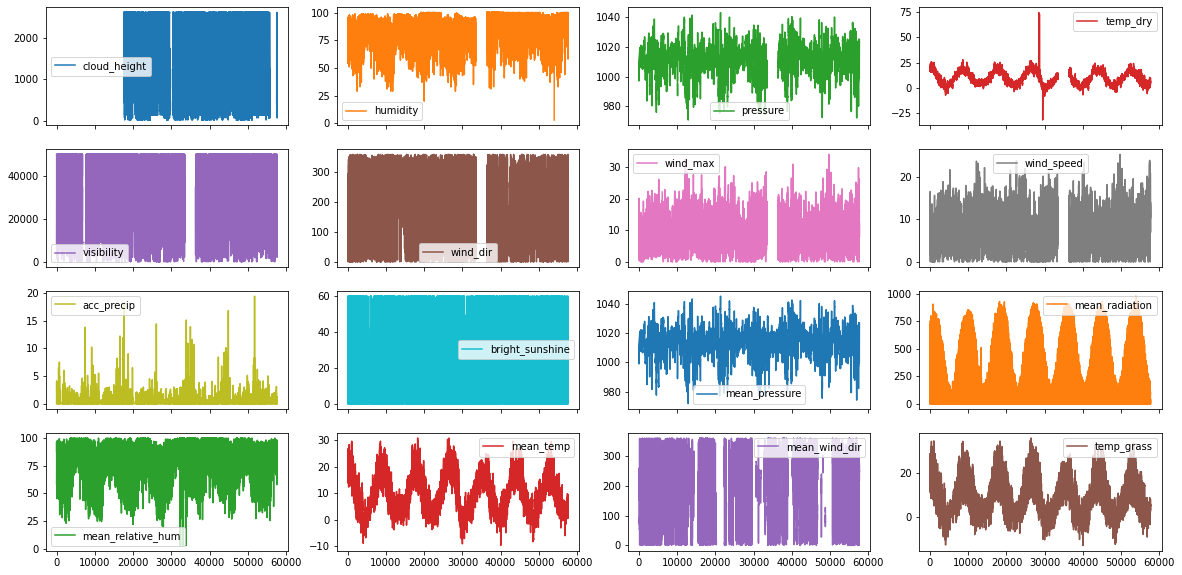

In [369]:
#len(merge_df[merge_df.columns[3:]].columns)

merge_df[merge_df.columns[3:]].plot(subplots=True, layout=(4,4), figsize = (20,10), sharex=True)

In [74]:
res, _ = conn.get(f'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items?limit=300000&stationId=06184&parameterId=cloud_cover&bbox=7,54,16,58&datetime=2015-01-01T00:00:00Z/2021-01-01T00:00:00Z&api-key={metObsAPIKey}', 'DMI Data')

In [75]:
res.json()

{'type': 'FeatureCollection',
 'features': [{'geometry': {'coordinates': [12.562, 55.716], 'type': 'Point'},
   'id': 'de9fa321-1728-a18c-d9ae-b7761f56973c',
   'type': 'Feature',
   'properties': {'created': '2021-01-20T05:43:30.817096Z',
    'observed': '2019-07-29T06:40:00Z',
    'parameterId': 'cloud_cover',
    'stationId': '06184',
    'value': 0.0}},
  {'geometry': {'coordinates': [12.562, 55.716], 'type': 'Point'},
   'id': 'f46e00f2-47ca-a98a-c3d9-5ff744bf8661',
   'type': 'Feature',
   'properties': {'created': '2021-01-20T05:43:30.813530Z',
    'observed': '2019-07-29T06:30:00Z',
    'parameterId': 'cloud_cover',
    'stationId': '06184',
    'value': 0.0}},
  {'geometry': {'coordinates': [12.562, 55.716], 'type': 'Point'},
   'id': '234be04a-9f1b-cb86-2016-16e68611a609',
   'type': 'Feature',
   'properties': {'created': '2021-01-20T05:43:30.810524Z',
    'observed': '2019-07-29T06:20:00Z',
    'parameterId': 'cloud_cover',
    'stationId': '06184',
    'value': 0.0}},
  {'

In [77]:
metObs_list = [ 'wind_max', 'visib_mean_last10min', 'temp_soil_max_past1h', 'cloud_height', 'temp_mean_past1h', 'wind_speed_past1h', 'wind_dir_past1h', 'pressure', 'humidity_past1h']

climate_list = ['bright_sunshine', 'mean_radiation', 'mean_pressure', 'acc_precip', 'temp_grass', 'mean_relative_hum', 'mean_temp']

# Updated climate and metObs stat list - updated according to the above graph to fill in as many NA as possible

metObs_listV1 = [ 'wind_max_per10min_past1h', 'visib_mean_last10min', 'temp_soil_max_past1h', 'cloud_height', 'cloud_cover']
metObs_listV2 = [ 'wind_max_per10min_past1h', 'temp_soil_max_past1h', 'cloud_cover']

climate_listV1 = ['bright_sunshine', 'mean_radiation', 'mean_pressure', 'acc_precip', 'temp_grass', 'mean_relative_hum', 'mean_temp', 'mean_wind_speed' ,'mean_wind_dir']

df_dmi = total_pipeline(metObs_listV2, climate_listV1, '2015-01-01', '2021-01-01')


  0%|          | 0/3 [00:00<?, ?it/s]

INFO: Running metObs pipeline


  0%|          | 0/9 [00:00<?, ?it/s]

INFO: Running Climate data pipeline


100%|██████████| 9/9 [03:50<00:00, 25.57s/it]


INFO: Merging the climate and metObs data together
INFO: Done


In [127]:
df_Nordpool_new = df_Nordpool.copy()
df_Nordpool_new['date'] = df_Nordpool_new['date'].astype('string')

df_dmi_new = df_dmi.copy()
df_dmi_new['date'] = df_dmi_new['date'].astype('string')

commodities_df_new = commodities_df.ffill().copy()
commodities_df_new['date'] = commodities_df_new['date'].astype('string')

first_merge = df_dmi_new.merge(df_Nordpool_new, on = ['date', 'hour'], how = 'left')
second_merge = first_merge.merge(commodities_df_new, on = 'date', how = 'left')

In [134]:
second_merge.to_csv('exam_df.csv')

In [118]:
df_total = pd.read_csv('exam_df.csv')
df_total.drop(['DK1 - NL','Unnamed: 0'], axis = 1, inplace = True)
#df_total.dropna(inplace = True)
new_mean = df_total[df_total.duplicated(['date', 'hour'])].groupby(['date', 'hour']).mean().reset_index()
df_total.drop_duplicates(['date', 'hour'],  keep = False, inplace = True)
df_concat_mean = pd.concat([df_total, new_mean]).sort_values(['date', 'hour']).reset_index(drop = True)


In [141]:
for i in df_concat_mean.columns:
    num_na = len(df_concat_mean[i].iloc[10920:]) - len(df_concat_mean[i].iloc[10920:].dropna())
    #if num_na > 100:
    print(f"{i}: {num_na}")

date: 0
hour: 0
cloud_cover: 6
temp_soil_max_past1h: 139
wind_max_per10min_past1h: 45
acc_precip: 4
bright_sunshine: 5
mean_pressure: 4
mean_radiation: 5
mean_relative_hum: 4
mean_temp: 4
mean_wind_dir: 4
mean_wind_speed: 4
temp_grass: 160
SYS: 4
DK1: 4
DK2: 4
DK1_CP: 4
DK2_CP: 4
DK1_PP: 4
DK2_PP: 4
DK1_WP: 4
DK2_WP: 4
DK net exchange: 4
DK1 net exchange: 4
DK2 net exchange: 4
DK - DE: 5
DK - NO: 5
DK - SE: 5
DK1 - SE3: 5
DK2 - SE4: 5
DK1 - DE: 5
DK2 - DE: 5
DK1 - DK2: 5
gold: 0
silver: 0
crude-oil: 0
rotterdam-coal-futures: 0
natural-gas: 0
carbon-emissions: 0


In [157]:
df_new_total = df_concat_mean.iloc[10944:]
df_new_total.ffill(inplace = True)
df_new_total.dropna(inplace = True)
df_new_total.to_csv('new_exam_df.csv')

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-157-8b31dcdc3c7b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_total.dropna(inplace = True)


In [156]:
df_new_total

date  hour  cloud_cover  temp_soil_max_past1h  \
10944  2016-04-01     0          0.0                   6.7   
10945  2016-04-01     1          0.0                   6.6   
10946  2016-04-01     2          0.0                   6.4   
10947  2016-04-01     3         10.0                   6.4   
10948  2016-04-01     4          0.0                   6.4   
...           ...   ...          ...                   ...   
52604  2020-12-31    20         90.0                   4.6   
52605  2020-12-31    21        100.0                   4.5   
52606  2020-12-31    22        100.0                   4.5   
52607  2020-12-31    23         90.0                   4.5   
52608  2021-01-01     0         90.0                   4.5   

       wind_max_per10min_past1h  acc_precip  bright_sunshine  mean_pressure  \
10944                       7.8         0.0              0.0         1015.1   
10945                       8.0         0.0              0.0         1015.2   
10946                       7.8         0.0              0.0         1015.2   
10947                       7.8         0.0              0.0         1015.2   
10948                       7.8         0.0              0.0         1015.2   
...                         ...         ...              ...            ...   
52604                       2.4         0.5              0.0         1003.2   
52605                      10.1         0.9              0.0         1003.5   
52606                       9.1         1.8              0.0         1003.7   
52607                      10.3         0.5              0.0         1003.9   
52608                       9.6         0.1              0.0         1004.0   

       mean_radiation  mean_relative_hum  ...  DK2 - SE4  DK1 - DE  DK2 - DE  \
10944             0.0               73.8  ...       60.3      -0.2     -58.5   
10945             0.0               78.0  ...      -25.8       0.4      -2.4   
10946             0.0               81.2  ...      -34.3       0.6       0.0   
10947             0.0               83.7  ...      -29.0      -5.1       0.3   
10948             0.0               85.5  ...      -30.1      -5.1      13.2   
...               ...                ...  ...        ...       ...       ...   
52604             1.0               91.0  ...       97.3    -204.2     -58.3   
52605             1.0               91.7  ...       75.2    -179.0     -50.0   
52606             1.0               92.8  ...       98.8    -187.6     -54.3   
52607             1.0               93.7  ...       96.4    -220.4     -43.8   
52608             1.0               91.2  ...      118.6    -241.1     -56.6   

       DK1 - DK2    gold  silver  crude-oil  rotterdam-coal-futures  \
10944      -58.3  1268.9  15.939      36.79                   44.85   
10945      -58.4  1268.9  15.939      36.79                   44.85   
10946      -58.9  1268.9  15.939      36.79                   44.85   
10947      -58.1  1268.9  15.939      36.79                   44.85   
10948      -52.3  1268.9  15.939      36.79                   44.85   
...          ...     ...     ...        ...                     ...   
52604       -4.6  1905.8  26.589      48.52                   69.00   
52605       -4.5  1905.8  26.589      48.52                   69.00   
52606       13.0  1905.8  26.589      48.52                   69.00   
52607       32.1  1905.8  26.589      48.52                   69.00   
52608       28.5  1901.6  26.525      48.52                   69.00   

       natural-gas  carbon-emissions  
10944        1.956              5.16  
10945        1.956              5.16  
10946        1.956              5.16  
10947        1.956              5.16  
10948        1.956              5.16  
...            ...               ...  
52604        2.539             32.72  
52605        2.539             32.72  
52606        2.539             32.72  
52607        2.539             32.72  
52608        2.539             32.72  

[41665 rows x 40 columns]

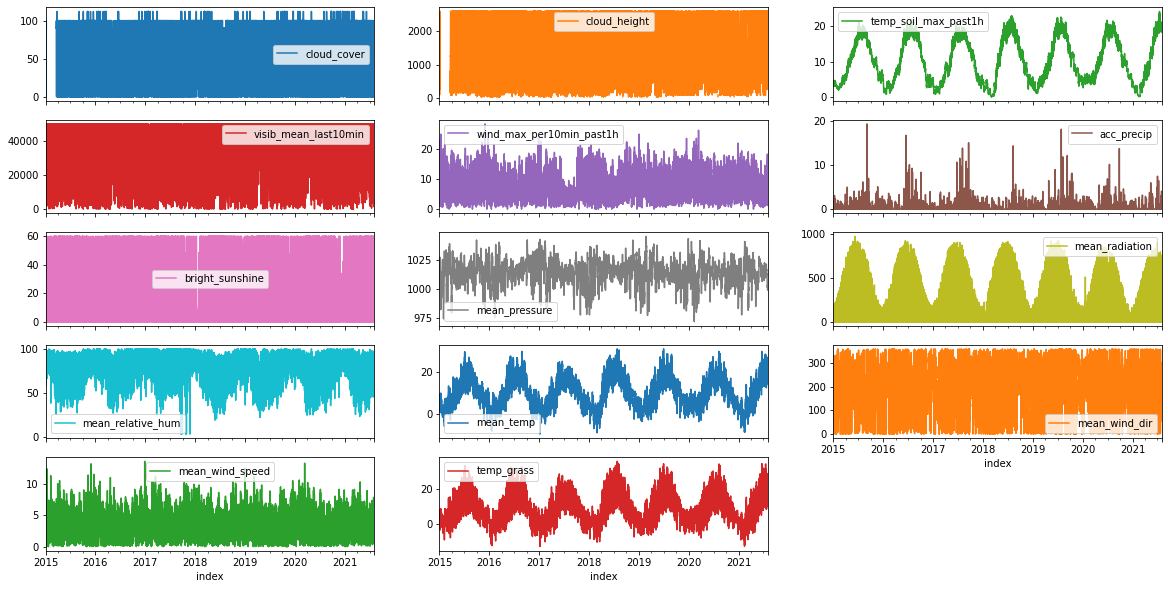

In [17]:
df[df.columns[2:]].plot(subplots=True, layout=(5,3), figsize = (20,10), sharex=True);

# Get data from https://www.investing.com/

In [43]:
url = 'https://www.investing.com/commodities/rotterdam-coal-futures-historical-data'

path = '/Users/simonjuulhansen/Desktop/Polit/ISDS/chromedriver'
driver = webdriver.Chrome(executable_path=path)
driver.get(url)
time.sleep(5)
menu = driver.find_element_by_css_selector('#widgetFieldDateRange')
  
ActionChains(driver).click(menu).perform()

enterValue1 = '01/01/2015'
enterValue2 = '01/01/2021'

inputElement1 = driver.find_element_by_id("startDate")
inputElement1.clear()
inputElement1.send_keys(enterValue1)

inputElement2 = driver.find_element_by_id("endDate")
inputElement2.clear()
inputElement2.send_keys(enterValue2)

driver.find_element_by_id("applyBtn").click();

time.sleep(3)

results = driver.find_elements_by_xpath('//*[(@id = "curr_table")]//td')
print('Number of results', len(results))

Number of results 10801


In [62]:
def getCommodityData(commodity, startDate, endDate):
    # The commodity has to be specified in the form of '-'.join(commodity_name) e.g. rotterdam-coal-futures or crude-oil.
    url = lambda id: f'https://www.investing.com/commodities/{id}-historical-data'
    temp_url = url(commodity)
    startDate = datetime.datetime.strptime(startDate, "%Y-%m-%d").strftime('%m/%d/%Y')
    endDate = datetime.datetime.strptime(endDate, "%Y-%m-%d").strftime('%m/%d/%Y')

    # Insert the path to your Chrome Driver.
    path = '/Users/simonjuulhansen/Desktop/Polit/ISDS/chromedriver'
    driver = webdriver.Chrome(executable_path=path)

    # Create a request interceptor
    def interceptor(request):
        request.headers['Contact_details'] = 'qxd466@alumni.ku.dk'
        request.headers['Purpose'] = "Dear recipient, we've scraped your data with the purpose of creating an academic report on electricity prices and if it's possible to predict these. Please contact us at via the contact details, if there's any issue with this. Best regards."

    # Set the interceptor on the driver
    driver.request_interceptor = interceptor
    
    driver.get(temp_url)
    
    time.sleep(3)

    # Accept cookies
    cookies = driver.find_element_by_css_selector('#onetrust-accept-btn-handler')
    ActionChains(driver).click(cookies).perform()

    time.sleep(1)

    # Opens the date range menu
    menu = driver.find_element_by_css_selector('#widgetFieldDateRange')
    ActionChains(driver).click(menu).perform()

    # Enters the date values. The dates have to be in the form of DD/MM/YYYY e.g. 01/01/2000.
    # This formatting is done in the above conversion of the start and end date from YYYY-MM-DD.
    inputElement1 = driver.find_element_by_id("startDate")
    inputElement1.clear()
    inputElement1.send_keys(startDate)

    inputElement2 = driver.find_element_by_id("endDate")
    inputElement2.clear()
    inputElement2.send_keys(endDate)

    # Applies the new dates
    driver.find_element_by_id("applyBtn").click();

    time.sleep(3)

    # Gets the results from the webpage
    results = driver.find_elements_by_xpath('//*[(@id = "curr_table")]//td')

    # Store the results in a DataFrame
    d = defaultdict(list)
    date_counter = 0
    value_counter = 1
    while True:
        try:
            d['date'].append(results[date_counter].text)
            d[commodity].append(results[value_counter].text)
            date_counter += 7
            value_counter += 7
        except IndexError:
            break
    df = pd.DataFrame(d)
    df['date'] = pd.to_datetime(df['date'], format = '%b %d, %Y')

    driver.quit()
    
    return df

In [28]:
list_of_commodities = ['natural-gas', 'carbon-emissions']
dict_df = dict()

for i in tqdm(list_of_commodities):
    dict_df[i] = getCommodityData(i, '2015-01-01', '2021-01-08')

date_range = pd.date_range(start='2015-01-01', end='2021-01-08', freq = 'D').to_pydatetime().tolist()
df_one = pd.DataFrame(date_range, columns = ['date'])

for i in dict_df.values():
    df_one = df_one.merge(i, on = 'date', how = 'left')
    df_one[i.columns[-1]] = df_one[i.columns[-1]].str.replace(',','').astype('float')

100%|██████████| 2/2 [03:22<00:00, 101.50s/it]


ValueError: Boolean array expected for the condition, not object

In [56]:
df_one

date  natural-gas  carbon-emissions
0    2015-01-01        2.841               NaN
1    2015-01-02        3.003              7.01
2    2015-01-03          NaN               NaN
3    2015-01-04          NaN               NaN
4    2015-01-05        2.882              6.90
...         ...          ...               ...
2195 2021-01-04        2.581             33.69
2196 2021-01-05        2.702             32.96
2197 2021-01-06        2.716             33.63
2198 2021-01-07        2.729             34.76
2199 2021-01-08        2.700             34.92

[2200 rows x 3 columns]

In [64]:
list_of_commodities = ['gold', 'silver', 'crude-oil', 'rotterdam-coal-futures', 'natural-gas', 'carbon-emissions']

def getAllCommodities(commodities, startDate, endDate):
    dict_df = dict()

    for i in tqdm(commodities):
        dict_df[i] = getCommodityData(i, startDate, endDate)

    date_range = pd.date_range(start=startDate, end=endDate, freq = 'D').to_pydatetime().tolist()
    df = pd.DataFrame(date_range, columns = ['date'])

    for i in dict_df.values():
        df = df.merge(i, on = 'date', how = 'left')
        df[i.columns[-1]] = df[i.columns[-1]].str.replace(',','').astype('float')

    df = df.ffill()
    return df

In [65]:
commodities_df = getAllCommodities(list_of_commodities, '2015-01-01', '2021-01-01')

100%|██████████| 6/6 [10:03<00:00, 100.52s/it]


In [67]:
commodities_df.ffill()

date    gold  silver  crude-oil  rotterdam-coal-futures  \
0    2015-01-01  1186.8  15.813      54.56                     NaN   
1    2015-01-02  1337.7  15.734      52.69                   65.50   
2    2015-01-03  1337.7  15.734      52.69                   65.50   
3    2015-01-04  1337.7  15.740      52.69                   65.50   
4    2015-01-05  1353.5  16.179      50.04                   63.75   
...         ...     ...     ...        ...                     ...   
2188 2020-12-28  1890.8  26.704      47.62                   71.65   
2189 2020-12-29  1893.4  26.388      48.00                   70.00   
2190 2020-12-30  1904.0  26.753      48.40                   69.40   
2191 2020-12-31  1905.8  26.589      48.52                   69.00   
2192 2021-01-01  1901.6  26.525      48.52                   69.00   

      natural-gas  carbon-emissions  
0           2.841               NaN  
1           3.003              7.01  
2           3.003              7.01  
3           3.003              7.01  
4           2.882              6.90  
...           ...               ...  
2188        2.305             33.44  
2189        2.467             33.02  
2190        2.422             32.19  
2191        2.539             32.72  
2192        2.539             32.72  

[2193 rows x 7 columns]

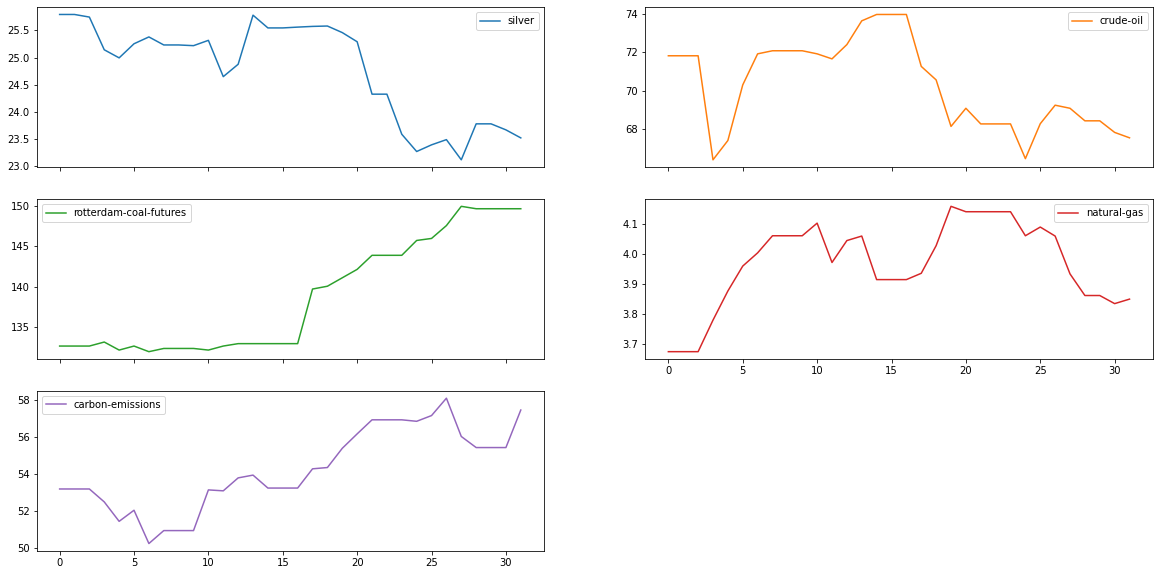

In [73]:
commodities_df.ffill()
commodities_df.ffill()[commodities_df.ffill().columns[2:]].plot(subplots=True, layout=(3,2), figsize = (20,10), sharex=True);

# DEPRECIATED FUNCTIONS

In [ ]:
def climateData(stat, start_date, end_date, stationId = '06184',apiKey = climateDataAPIKEy):
    """
    Function that takes a parameter ID and searches for all observations from DMI
    for the given dates, where the date format is given as 'YYYY-MM-DD'
    """

    # Define constants to be used in the function
    url= lambda API_KEY, id, startDate, endDate, stationId: f'https://dmigw.govcloud.dk/v2/climateData/collections/stationValue/items?timeResolution=hour&limit=300000&stationId={stationId}&parameterId={id}&datetime={startDate}T00:00:00Z/{endDate}T00:00:00Z&api-key={API_KEY}'
    local_counter = 1
    ErrorCounter = 0
    stationCounter = 0
    stationList = ['06181', '06186', '06187', '06188']

    while True:
        try:
            temp_url = url(apiKey, stat, start_date, end_date, stationId)
            ErrorCounter += 1

            res, _ = conn.get(temp_url, 'DMI Data')
            json_dmi = res.json()
            prop = [item['properties'] for item in json_dmi['features']]
            temp_df = pd.DataFrame(prop)
            
            temp_df['to'].drop_duplicates(inplace = True)
            temp_df.index = pd.to_datetime(temp_df['to'])
            #temp_df = temp_df.tz_convert('CET')

            if temp_df.index[-1].date() != datetime.date.fromisoformat(start_date):
                            
                if local_counter == 1:
                    df = temp_df.copy()
                    local_counter += 1
                elif local_counter > 1:
                    df = pd.concat([df,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in IF")

                end_date = temp_df.index[-1].date().strftime("%Y-%m-%d")
                #warnings.warn('Loop loop date wrong')
                continue
            else:
                if local_counter == 1:
                    df = temp_df
                elif local_counter > 1:
                    df = pd.concat([df,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in ELSE")

                break
            


        except KeyError as e:

            try:
                stationId = stationList[stationCounter]
                stationCounter += 1
                #warnings.warn('Loop loop station wrong')
                continue
            except IndexError as i:
                if ErrorCounter == 1:
                    warnings.warn(f"The requested stat {stat} isn't available for any default stations")
                else:
                    warnings.warn(f"The requested stat {stat} isn't available for any default stations for the daterange: {start_date} - {end_date}")
                return None
        
    return df


In [ ]:
def metObsData(stat, start_date, end_date, stationId = '06183', apiKey = metObsAPIKey):
    """
    Function that takes a parameter ID and searches for all observations from DMI
    for the given dates, where the date format is given as 'YYYY-MM-DD'
    """

    # Define constants to be used in the function
    url= lambda API_KEY, id, startDate, endDate, stationId: f'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items?limit=300000&stationId={stationId}&parameterId={id}&bbox=7,54,16,58&datetime={startDate}T00:00:00Z/{endDate}T00:00:00Z&api-key={API_KEY}'
    local_counter = 1
    ErrorCounter = 0
    stationCounter = 0
    stationList = ['06184', '06186', '06187', '06188']

    while True:
        try:
            temp_url = url(apiKey, stat, start_date, end_date, stationId)
            ErrorCounter += 1

            res, _ = conn.get(temp_url, 'DMI Data')
            json_dmi = res.json()
            prop = [item['properties'] for item in json_dmi['features']]
            temp_df = pd.DataFrame(prop)
            
            temp_df['observed'].drop_duplicates(inplace = True)
            temp_df.index = pd.to_datetime(temp_df['observed'])
            temp_df = temp_df.tz_convert('CET')

            if temp_df.index[-1].date() != datetime.date.fromisoformat(start_date):
                            
                if local_counter == 1:
                    df = temp_df.copy()
                    local_counter += 1
                elif local_counter > 1:
                    df = pd.concat([df,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in IF")

                end_date = temp_df.index[-1].date().strftime("%Y-%m-%d")
                continue
            else:
                if local_counter == 1:
                    df = temp_df
                elif local_counter > 1:
                    df = pd.concat([df,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in ELSE")

                break
            


        except KeyError as e:

            try:
                stationId = stationList[stationCounter]
                stationCounter += 1
                continue
            except IndexError as i:
                if ErrorCounter == 1:
                    warnings.warn(f"The requested stat {stat} isn't available for any default stations")
                else:
                    warnings.warn(f"The requested stat {stat} isn't available for any default stations for the daterange: {start_date} - {end_date}")
                return None
        
    return df

        
    